In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cv2
import os

In [54]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

images = np.array(load_images_from_folder('dinos'))[0:2]
cv2.imshow('window', images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

: 

In [41]:
K = np.loadtxt("intrinsic_matrix.txt", dtype=float)

In [42]:
# height, width, ch = images.shape[1:4]
# K = np.array([  # for dino
#     [2360, 0, width / 2],
#     [0, 2360, height / 2],
#     [0, 0, 1]])

In [43]:
# def load_data(path='cameras'):

#     C1 = np.load(f'{path}/cam1.npz')
#     C2 = np.load(f'{path}/cam2.npz')
#     K1 = C1['K']
#     K2 = C2['K']

#     return K1

# K = load_data()

In [44]:
# Feature extraction
orb = cv2.SIFT_create()

kp, des = [], []
for im in images:
    kp_tmp, des_tmp = orb.detectAndCompute(im, None)
    kp.append(kp_tmp)
    des.append(des_tmp)
print(len(kp[0])) #kp.shape = n_images x n_keypoints
print(des[0].shape) #des.shape = n_images x n_keypoints x descriptor_size

1429
(1429, 128)


In [45]:
# Inicializar el emparejador FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = {}
# Comparar cada imagen con todas las demás
for i in range(len(images)):
    for j in range(i+1, len(images)):
        # Emparejar descriptores
        matches_tmp = flann.knnMatch(des[i], des[j], k=2)

        # Aplicar la prueba de ratio para encontrar buenos emparejamientos (prueba de ratio de Lowe)
        good_matches = [m for m, n in matches_tmp if m.distance < 0.7 * n.distance]

        # Comprobar si hay suficientes buenos emparejamientos
        if len(good_matches) >= 4:
            # Aplicar RANSAC para encontrar la matriz de homografía y obtener la máscara de inliers
            src_pts = np.float32([kp[i][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[j][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Obtener solo los inliers
            inliers = [good_matches[k] for k in range(len(good_matches)) if mask[k]==1]
            matches[(i,j)] = inliers
            
            # Ahora la variable 'inliers' contiene solo los emparejamientos inliers
            print(f'Número de inliers: {len(inliers)}')
        else:
            matches[(i,j)] = []
            print(f"No hay suficientes buenos emparejamientos entre las imágenes para calcular la homografía.")

Número de inliers: 382


C:\Users\adria\AppData\Local\Temp\ipykernel_35024\2678752623.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



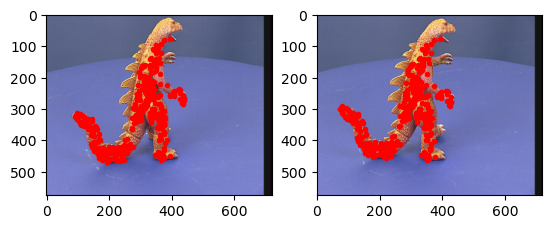

In [46]:
pts1 = np.array([kp[0][m.queryIdx].pt for m in matches[(0,1)]]).T
pts2 = np.array([kp[1][m.trainIdx].pt for m in matches[(0,1)]]).T

fig, ax = plt.subplots(1, 2)
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
ax[0].plot(pts1[0], pts1[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
ax[1].plot(pts2[0], pts2[1], 'r.')
fig.show()

In [47]:
# Fundamental Matrix

def normalize_points(pts):
    centroid = np.mean(pts, axis=0)
    pts = pts-centroid
    scale=np.sqrt(2)/np.mean(np.sqrt(np.sum(pts**2, axis=1)))
    pts = pts * scale
    T = np.array([[scale, 0, -scale*centroid[0]], [0, scale, -scale*centroid[1]], [0, 0, 1]])
    return pts, T

def eight_point_algorithm(pts1, pts2):
    # Normalize the points
    pts1, T1 = normalize_points(pts1)
    pts2, T2 = normalize_points(pts2)

    # Create constraint matrix A (Af=0), each A element is [(xi, xi),(xi)
    A = np.zeros((len(pts1), 9))
    for i in range(len(pts1)):
        A[i] = [pts1[i,0]*pts2[i,0], pts1[i,1]*pts2[i,0], 1*pts2[i,0],
                pts1[i,0]*pts2[i,1], pts1[i,1]*pts2[i,1], 1*pts2[i,1],
                pts1[i,0]*1,            pts1[i,1]*2,         1*1]
    
    # f is equal to last column of V from svd of A
    _, _, V = np.linalg.svd(A)
    F = np.reshape(V[-1], (3, 3))

    # Enforce rank 2 constraint F=U * diag(S) * V.T
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ V.T

    return F

fundamental_matrices = []
for i in range(len(kp) - 1):
    pts1 = np.array([kp[i][m.queryIdx].pt for m in matches[(i,i+1)]])
    pts2 = np.array([kp[i+1][m.trainIdx].pt for m in matches[(i,i+1)]])
    F = eight_point_algorithm(pts1, pts2)
    fundamental_matrices.append(F)
fundamental_matrices = np.array(fundamental_matrices) # fundamental_matrices.shape = n_images-1[skipped first image] x (3x3 -> F matrix)

In [48]:
# Essential matrix
def essential_from_fundamental(K, F):
    return K.T @ F @ K

essential_matrices = []
for F in fundamental_matrices:
    E = essential_from_fundamental(K, F)
    essential_matrices.append(E)
essential_matrices = np.array(essential_matrices) # essential_matrices.shape = n_images-1[skipping first image] x (3x3 -> E matrix)

In [49]:
# First camera initializes at world center aligned
Ps = np.zeros((images.shape[0], 3, 4))
Ps[0] = K @ np.hstack((np.identity(3), np.zeros(3)[:, np.newaxis]))

In [50]:
# Get Rotation and Translation

def get_rot_trans(E):
    U,S,V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U @ np.array([[m, 0, 0], [0, m, 0], [0, 0, 0]]) @ V
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])

    RTs = np.zeros([3, 4, 4])
    RTs[:, :, 0] = np.concatenate([U @ W @ V, U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()], axis=1)
    RTs[:, :, 1] = np.concatenate([U @ W @ V, -U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()], axis=1)
    RTs[:, :, 2] = np.concatenate([U @ W.T @ V, U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()], axis=1)
    RTs[:, :, 3] = np.concatenate([U @ W.T @ V, -U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()], axis=1)
    return RTs

rot_trans_list = []
for E in essential_matrices:
    RTs = get_rot_trans(E)
    rot_trans_list.append(RTs)
rot_trans_list = np.array(rot_trans_list) # rot_trans_list.shape = n_images - 1 x (3x4 -> [R|t]) x 4 possibilities

In [51]:
# Choose matrix that has all points in front and minimizes reprojection loss

def triangulate(pts1, pts2, P1, P2):
    # Calculate 3D point
    pts4D = np.zeros((4, pts1.shape[1]))
    pts4D = cv2.triangulatePoints(P1, P2, pts1, pts2, pts4D)
    pts4D /= pts4D[-1, :]

    # Calculate reprojection error
    # First, get reprojections
    pts1_reproj = P1 @ pts4D
    pts2_reproj = P2 @ pts4D

    pts1_reproj /= pts1_reproj[-1, :]
    pts2_reproj /= pts2_reproj[-1, :]

    # Second, homogenize every point to compare with the reprojection
    # pts1 (2xN)
    pts1_homo = np.concatenate((pts1, np.ones((1, pts1.shape[1]))), axis=0)
    pts2_homo = np.concatenate((pts2, np.ones((1, pts2.shape[1]))), axis=0)

    err1 = np.sum(np.square(pts1_reproj - pts1_homo))
    err2 = np.sum(np.square(pts2_reproj - pts2_homo))

    err = err1 + err2
    return pts4D[:3, :], err

for i in range(rot_trans_list.shape[0]):
    RT = rot_trans_list[i]
    best_RT = np.zeros((3, 4))
    best_error = np.finfo('float').max
    for j in range(RTs.shape[2]):
        RT = RTs[:, :, j]
        P2_tmp = K @ RT
        pts1 = np.array([kp[i][m.queryIdx].pt for m in matches[(i, i+1)]]).astype('float').T
        pts2 = np.array([kp[i+1][m.trainIdx].pt for m in matches[(i, i+1)]]).astype('float').T
        X, err = triangulate(pts1, pts2, Ps[i], P2_tmp)
        if err < best_error and np.all(X[-1, :] >= 0):
            best_error = err
            P = X
            Ps[i+1] = P2_tmp
            best_RT = RT

Ps = np.array(Ps) # Ps.shape = n_images x (3x4 -> Projection Matrix)

In [52]:
import plotly.graph_objects as go

# Assuming points_3D is your array of 3D points
x = tripoints3d[0]
y = tripoints3d[1]
z = -tripoints3d[2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   marker=dict(size=2, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis_title='X',
                             yaxis_title='Y',
                             zaxis_title='Z'))

fig.show()